In [62]:
import numpy as np
from scipy.integrate import simps
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [2]:
def keep_cleaning(on, off, threshold=3.0, verbose=False):
    """Compute residuals from data after clean component subtraction. 
    The rms and baseline is determined from the "offpulse" time series, 
    and the signal strength is calculated from the "onpulse" region.
    """
    rms = np.std(off)
    #median = np.median(off) # median is more reliable than mean
    mean = np.mean(off)
    
    datamax = np.max(on)

    #limit = median + threshold * rms
    limit = mean + threshold * rms
    
    if datamax > limit:
        #if verbose:
        #    print("Onpulse data maximum still above threshold")
        #    print("{0:g} > {1:g}".format(datamax, limit))
        return True
    else:
        if verbose:
            print("No more data are above the given threshold ({0}-sigma)".format(threshold))
            print("    data max.={0}".format(datamax))
            print("    threshold={0}".format(threshold * rms))
        return False

In [3]:
def gaussian(x, mu, sigma):
    gaus = (1 / (np.sqrt(2) * sigma)) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return gaus / gaus.max()

In [4]:
def pbf1(x, x0, tau):
    h = (1 / tau) * np.exp(-(x-x0)/tau)
    h[x <= x0] = 0
    
    return h

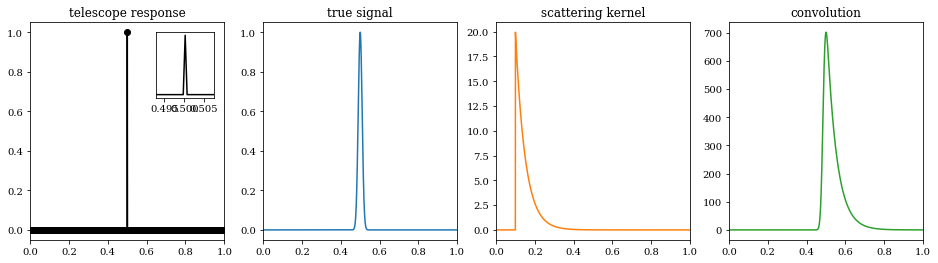

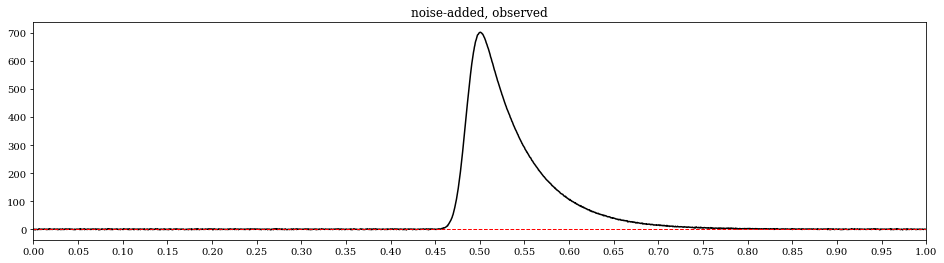

In [104]:
## Test deconvolution process
np.random.seed(11111)
nbins = 2048
x = np.linspace(0, 1, nbins)
x0 = 0.1

# Create intrinsic pulse shape
f = np.zeros_like(x)
f += gaussian(x, x[f.size//2], 0.01)
int_f = simps(y=f, x=x)

# Create telescope response function
response = np.zeros_like(f)
response[response.size//2] = 1.0 # i.e. assume response is a delta function
#response += gaussian(x, x[f.size//2], 0.0002)

# Create scattering kernel model
tau = 0.05
h = pbf1(x, x0, tau)

# Create the observed pulse shape
# The observed pulse shape is the convlution of:
# - the true signal, 
# - the scattering kernel, and 
# - the telescope response (+ noise)
g = np.convolve(f, h, mode="same")
g = np.convolve(g, response, mode="same")
offset = np.argmax(f) - np.argmax(g)
g = np.roll(g, offset)


# Add approriate noise to give desired signal-to-noise ratio
snr = 1000
data = np.copy(g) + np.random.normal(0, g.max() / snr, g.size)
data_init = np.copy(data)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=plt.figaspect(0.25), sharex=True)
ax1.plot(x, response, color="k", marker="o")
ax1ins = inset_axes(ax1, width="30%", height="30%", borderpad=1)
ax1ins.plot(x, response, color="k")
ax1ins.set_xlim(x[np.argmax(response)-15], x[np.argmax(response)+15])
ax1ins.set_yticks([])
ax2.plot(x, f, color="C0")
ax3.plot(x, h, color="C1")
ax4.plot(x, g, color="C2")
ax1.set_title("telescope response")
ax2.set_title("true signal")
ax3.set_title("scattering kernel")
ax4.set_title("convolution")
ax1.set_xlim(0, 1)

fig, ax = plt.subplots(ncols=1, figsize=plt.figaspect(0.25))
ax.plot(x, data, color="k")
ax.axhline(0, color="r", ls="--", lw=1)
ax.set_title("noise-added, observed")
ax.set_xlim(0, 1)
ax.set_xticks(np.arange(0,1.05, 0.05))


plt.show()

peak intensity=702.7319430061486
rms=0.7112915582634184
snr=987.9660946937602
on-pulse range=819:1843
No more data are above the given threshold (2.5-sigma)
    data max.=1.7568108604173203
    threshold=1.7761205319241593
Reached noise floor after 1145 iterations


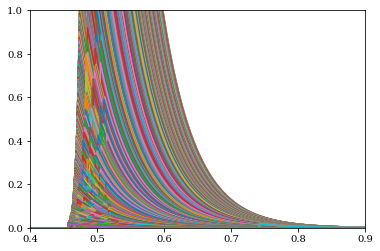

In [121]:
nbins = len(data_init)
clean_components = np.zeros_like(data)
gain = 0.01
filter_guess = pbf1(x, x0, tau)

on_lims = np.array([int(0.4*nbins), int(0.9*nbins)])
onpulse = data[on_lims[0]:on_lims[1]]
offpulse = np.concatenate((data[:on_lims[0]], data[on_lims[1]:]))
init_rms = np.std(offpulse)

#plt.plot(offpulse)
#plt.show()

#plt.plot(data)
#plt.axvline(on_lims[0])
#plt.axvline(on_lims[1])


print("peak intensity={0}".format(onpulse.max()))
print("rms={0}".format(init_rms))
print("snr={0}".format(onpulse.max()/init_rms))
thresh = 2.5
print("on-pulse range={0}:{1}".format(on_lims[0], on_lims[1]))

# Initialise counters and boolean checks
loop = True
niter = 0
profile = np.copy(data)
#response = np.zeros_like(f)
#response[data.size//2] = 1.0
while loop:
    
    imax = np.argmax(profile[on_lims[0]:on_lims[1]]) + on_lims[0]
    dmax = profile[imax]
    
    niter += 1
    
    temp_clean_comp = np.zeros_like(clean_components)
    temp_clean_comp[imax] = dmax * gain
    clean_components[imax] += dmax * gain
    
    rest_func = np.convolve(temp_clean_comp, response, mode="same")
    rest_func = np.convolve(rest_func, filter_guess, mode="same")
    rest_func = rest_func / np.max(rest_func)
    
    component = rest_func * temp_clean_comp[imax]
    offset = np.argmax(temp_clean_comp) - np.argmax(rest_func)
    component = np.roll(component, offset)
    
    cleaned = profile - component
    
    onpulse = cleaned[on_lims[0]:on_lims[1]]
    offpulse = np.concatenate((cleaned[:on_lims[0]], cleaned[on_lims[1]:]))
    
    loop = keep_cleaning(onpulse, offpulse, threshold=thresh, verbose=True)
    if not loop:
        print("Reached noise floor after {0} iterations".format(niter))
    

    plt.plot(x, component)
    #plt.plot(component, color="r")
    profile = np.copy(cleaned)
    
plt.xlim(on_lims / nbins)
plt.ylim(0,1)
plt.show()    



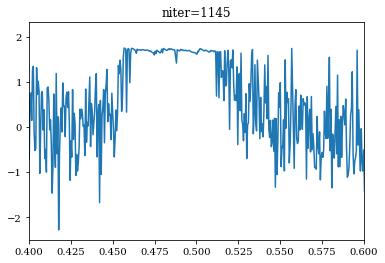

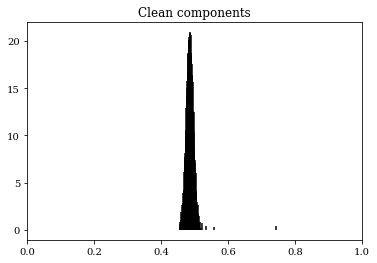

number of unique clean components created=118
total clean components added=1145
model offet=818
mean res. = -0.012166569068797203
rms res. = 0.7104482127696637


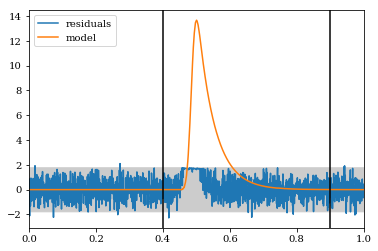

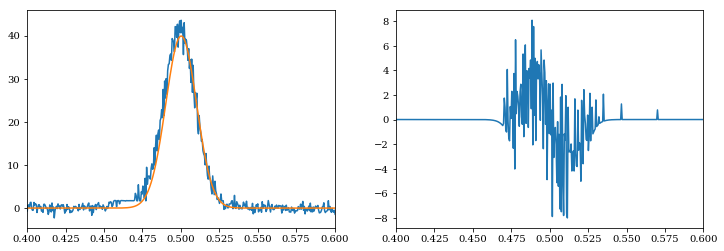

In [117]:
plt.plot(x, cleaned)
plt.title("niter={0}".format(niter))
plt.xlim(0.4,0.6)
plt.show()

plt.vlines(x, ymin=0, ymax=clean_components, color="k")
#plt.yscale("log", clip=True)
plt.xlim(0, 1)
plt.title("Clean components")
plt.show()

print("number of unique clean components created={0}".format(np.count_nonzero(clean_components)))
print("total clean components added={0}".format(niter))

model = np.convolve(clean_components, h, mode="same")
model_offset = abs(np.argmax(model) - np.argmax(data_init))
print("model offet={0}".format(model_offset))
model = np.roll(model, model_offset)
    
#residuals = data_init - model
residuals = cleaned

offpulse = np.concatenate((residuals[:on_lims[0]], residuals[on_lims[1]:]))
mean_offpulse = np.mean(offpulse)
rms_offpulse = np.std(offpulse)
print("mean res. = {0}".format(mean_offpulse))
print("rms res. = {0}".format(rms_offpulse))
upper = mean_offpulse + thresh*rms_offpulse
lower = mean_offpulse - thresh*rms_offpulse

    
#plt.plot(data_init, label="data")
plt.plot(x, residuals, label="residuals")
plt.plot(x, model/simps(x=x, y=model), label="model")
plt.fill_between(np.linspace(0, len(model)-1, len(model)), lower, upper, color="0.8")
plt.axvline(on_lims[0]/nbins, color="k")
plt.axvline(on_lims[1]/nbins, color="k")
plt.xlim(0, 1)
plt.legend()
plt.show()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=plt.figaspect(0.33), sharex=True)
recon = np.convolve(clean_components, response, mode="same")
recon_offset = abs(np.argmax(recon) - np.argmax(response))
recon = np.roll(recon, recon_offset)
int_r = simps(y=recon, x=x)
norm_r = recon/int_r
norm_f = f/int_f
diff = (norm_r - norm_f)
ax1.plot(x, norm_r+residuals, label="reconstructed")
ax1.plot(x, norm_f, label="true intrinsic")
ax2.plot(x, diff/rms_offpulse, label="frac. difference (units of off-pulse rms)")
ax1.set_xlim(0.4,0.6)
plt.show()
